In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, sosfiltfilt
from scipy.fft import fft, fftfreq
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# === Utility functions ===

def analytic_signal_fft(x):
    x = np.asarray(x)
    n = x.size
    X = np.fft.fft(x, n)
    h = np.zeros(n)
    if n % 2 == 0:
        h[0] = 1.0; h[n//2] = 1.0; h[1:n//2] = 2.0
    else:
        h[0] = 1.0; h[1:(n+1)//2] = 2.0
    return np.fft.ifft(X * h)

def rewrap(phi):
    return (phi + np.pi) % (2 * np.pi) - np.pi

def inst_freq_from_phase(phi, Fs):
    dphi = np.diff(phi)
    dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
    ifreq = (dphi / (2 * np.pi)) * Fs
    if np.any(np.isnan(ifreq)) or np.any(np.isinf(ifreq)):
        print(f"Warning: IF contains NaNs or infs")
        print(ifreq)
    return np.concatenate([ifreq, [np.nan]])

def repair_phase_with_pchip(phi_wrapped, bad_mask):
    phi_unwrapped = np.unwrap(phi_wrapped)
    phi_interp = phi_unwrapped.copy()
    phi_interp[bad_mask] = np.nan
    valid = ~np.isnan(phi_interp)
    if valid.sum() >= 2:
        xs = np.flatnonzero(valid)
        ys = phi_interp[valid]
        pchip = PchipInterpolator(xs, ys, extrapolate=False)
        phi_interp[~valid] = pchip(np.flatnonzero(~valid))
    return rewrap(phi_interp), phi_interp

def bandpass_wide(x, Fs, lo, hi, order=8):
    nyq = 0.5 * Fs
    sos = butter(order, [lo / nyq, hi / nyq], btype='bandpass', output='sos')
    return sosfiltfilt(sos, x)

# === General-purpose GP function for bandpassed or envelope signals ===

def generalized_phase(x, Fs, lo, hi, nwin=1, plot_debug=False, label_prefix=""):
    """
    Generalized phase extraction from a narrowband signal (filtered or amplitude envelope).

    Parameters:
        x : np.array
            Narrowband signal (bandpassed or amplitude envelope)
        Fs : float
            Sampling frequency
        lo, hi : float
            Valid frequency range for GP IF check (Hz)
        lp : float
            Lower bound of valid IF (Hz)
        nwin : int
            Multiplier for bad segment extension
        plot_debug : bool
            If True, plots signal, IF, bad regions, and GP phase
        label_prefix : str
            Label prefix for plots

    Returns:
        dict with keys: amp, phase_raw, phase_gp, ifreq, bad_mask
    """
    t = np.arange(len(x)) / Fs

    # Step 1: analytic signal
    z = analytic_signal_fft(x)
    amp = np.abs(z)
    phi = np.angle(z)

    # Step 2: instantaneous frequency
    from scipy.ndimage import gaussian_filter1d
    smoothed_phase = gaussian_filter1d(np.unwrap(phi), sigma=2)
    ifreq = inst_freq_from_phase(smoothed_phase, Fs)

    # Step 3: rotation rectify if needed
    if np.nanmedian(ifreq) < 0:
        z = amp * np.exp(1j * (-np.angle(z)))
        phi = np.angle(z)
        ifreq = inst_freq_from_phase(phi, Fs)

    # Step 4: identify and extend bad segments
    bad = (ifreq < lo) | (ifreq > hi)
    if len(bad) > 0:
        bad[0] = False
    n = len(bad)
    extended = np.zeros_like(bad, dtype=bool)
    i = 0
    while i < n:
        if bad[i]:
            j = i
            while j + 1 < n and bad[j + 1]:
                j += 1
            run_len = (j - i + 1)
            max_pad = int(Fs * 0.01)  # set max pad length in seconds
            pad = min(run_len * nwin, max_pad)
            start = max(0, i - pad)
            end = min(n - 1, j + pad)
            extended[start:end + 1] = True
            i = j + 1
        else:
            i += 1
    bad_ext = extended

    # Step 5: repair phase
    phi_gp, _ = repair_phase_with_pchip(phi, bad_ext)

    # Optional debug plotting
    if plot_debug:
        fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

        axs[0].plot(t, x, color='black')
        axs[0].set_ylabel("Signal")
        axs[0].set_title(f"{label_prefix} Input Signal")

        axs[1].plot(t, phi, '--', color='gray', label='Raw Phase')
        axs[1].set_ylabel("Phase (rad)")
        axs[1].set_title(f"{label_prefix} Raw Phase")

        print("ifreq contains NaNs:", np.any(np.isnan(ifreq)))
        print("ifreq contains Infs:", np.any(np.isinf(ifreq)))
        print("ifreq min:", np.nanmin(ifreq))
        print("ifreq max:", np.nanmax(ifreq))

        axs[2].plot(t, ifreq, label="IF", lw=0.5)
        axs[2].axhline(lo, linestyle='--', color='gray', lw=1)
        in_run = False
        for idx, b in enumerate(bad_ext):
            if b and not in_run:
                in_run = True
                start = idx
            if in_run and (idx == len(bad_ext) - 1 or not bad_ext[idx + 1]):
                end = idx
                axs[2].axvspan(t[start], t[end], alpha=0.2)
                in_run = False
        axs[2].set_ylabel("IF (Hz)")
        axs[2].set_title(f"{label_prefix} Bad segments extended (IF < lp or > hi)")
        if np.isfinite(np.nanmax(ifreq)):
            axs[2].set_ylim(-20, min(1.5 * hi, float(np.nanmax(ifreq)) + 5))

        axs[3].plot(t, phi_gp, label='GP Phase', color='tab:blue')
        axs[3].set_ylabel("Phase (rad)")
        axs[3].set_title(f"{label_prefix} GP Phase (repaired)")

        plt.tight_layout()
        plt.show()

    return {
        "amp": amp,
        "phase_raw": phi,
        "phase_gp": phi_gp,
        "ifreq": ifreq,
        "bad_mask": bad_ext
    }

def analyze_phase_amplitude_structure(signal, Fs, bands, order=8, envelope_bands=None, fig_title=None, plot_debug=False):
    """
    Plot the raw signal and, for each band:
    - Bandpassed signal
    - Raw vs GP phase
    - (Optional) Amplitude envelope and its GP phase (only for envelope_bands)

    Parameters:
        signal : np.array
            Raw input signal
        Fs : float
            Sampling frequency (Hz)
        bands : list of (lo, hi)
            Frequency bands to filter and analyze
        order : int
            Filter order for bandpass
        envelope_bands : list of (lo, hi), optional
            Bands for which to compute amplitude envelope and envelope phase
        fig_title : str, optional
            Title to display above the figure
    """
    
    if envelope_bands is None:
        envelope_bands = []

    t = np.arange(len(signal)) / Fs
    n_bands = len(bands)

    # Count total rows needed
    nrows = 1  # Raw signal
    for band in bands:
        nrows += 2  # filtered + phase
        if band in envelope_bands:
            nrows += 2  # amp + envelope phase

    # Create figure
    fig = plt.figure(figsize=(12, 2.2 * nrows))
    gs = gridspec.GridSpec(nrows, 1, hspace=0.6)

    if fig_title:
        fig.suptitle(fig_title, fontsize=14)

    row = 0
    ax = fig.add_subplot(gs[row, 0])
    ax.plot(t, signal, color='black')
    ax.set_title("Raw Signal")
    ax.set_ylabel("Amplitude")
    row += 1

    for band in bands:
        lo, hi = band
        # Filter
        filt = bandpass_wide(signal, Fs, lo, hi, order=order)

        # Run GP on the filtered signal
        result = generalized_phase(filt, Fs, lo, hi, label_prefix=f"{lo}-{hi} Hz ", plot_debug=plot_debug)

        # Plot: bandpassed
        ax = fig.add_subplot(gs[row, 0])
        ax.plot(t, filt, color='black')
        ax.set_title(f"{lo}–{hi} Hz Bandpassed Signal")
        ax.set_ylabel("Amplitude")
        row += 1

        # Plot: phase
        ax = fig.add_subplot(gs[row, 0])
        ax.plot(t, result["phase_raw"], '--', color='gray', label="Raw Phase")
        ax.plot(t, result["phase_gp"], color='tab:blue', label="GP Phase")
        ax.set_ylabel("Phase (rad)")
        ax.set_title(f"{lo}–{hi} Hz Phase")
        ax.legend()
        row += 1

        if band in envelope_bands:
            # Run GP on the envelope
            amplitude = bandpass_wide(result["amp"], Fs, lo=1.0, hi=70.0)
            env_result = generalized_phase(amplitude, Fs, lo=0.1, hi=20.0, label_prefix=f"{lo}-{hi} Hz Envelope ", plot_debug=plot_debug)

            # Plot: amplitude
            ax = fig.add_subplot(gs[row, 0])
            ax.plot(t, result["amp"], color='black')
            ax.set_ylabel("Amplitude")
            ax.set_title(f"{lo}–{hi} Hz Amplitude Envelope")
            row += 1

            # Plot: envelope phase
            ax = fig.add_subplot(gs[row, 0])
            ax.plot(t, env_result["phase_raw"], '--', color='gray', label="Env Phase (raw)")
            ax.plot(t, env_result["phase_gp"], color='tab:green', label="Env Phase (GP)")
            ax.set_ylabel("Phase (rad)")
            ax.set_title(f"{lo}–{hi} Hz Envelope Phase")
            ax.legend()
            row += 1

    ax.set_xlabel("Time (s)")
    fig.subplots_adjust(top=0.94)
    plt.show()

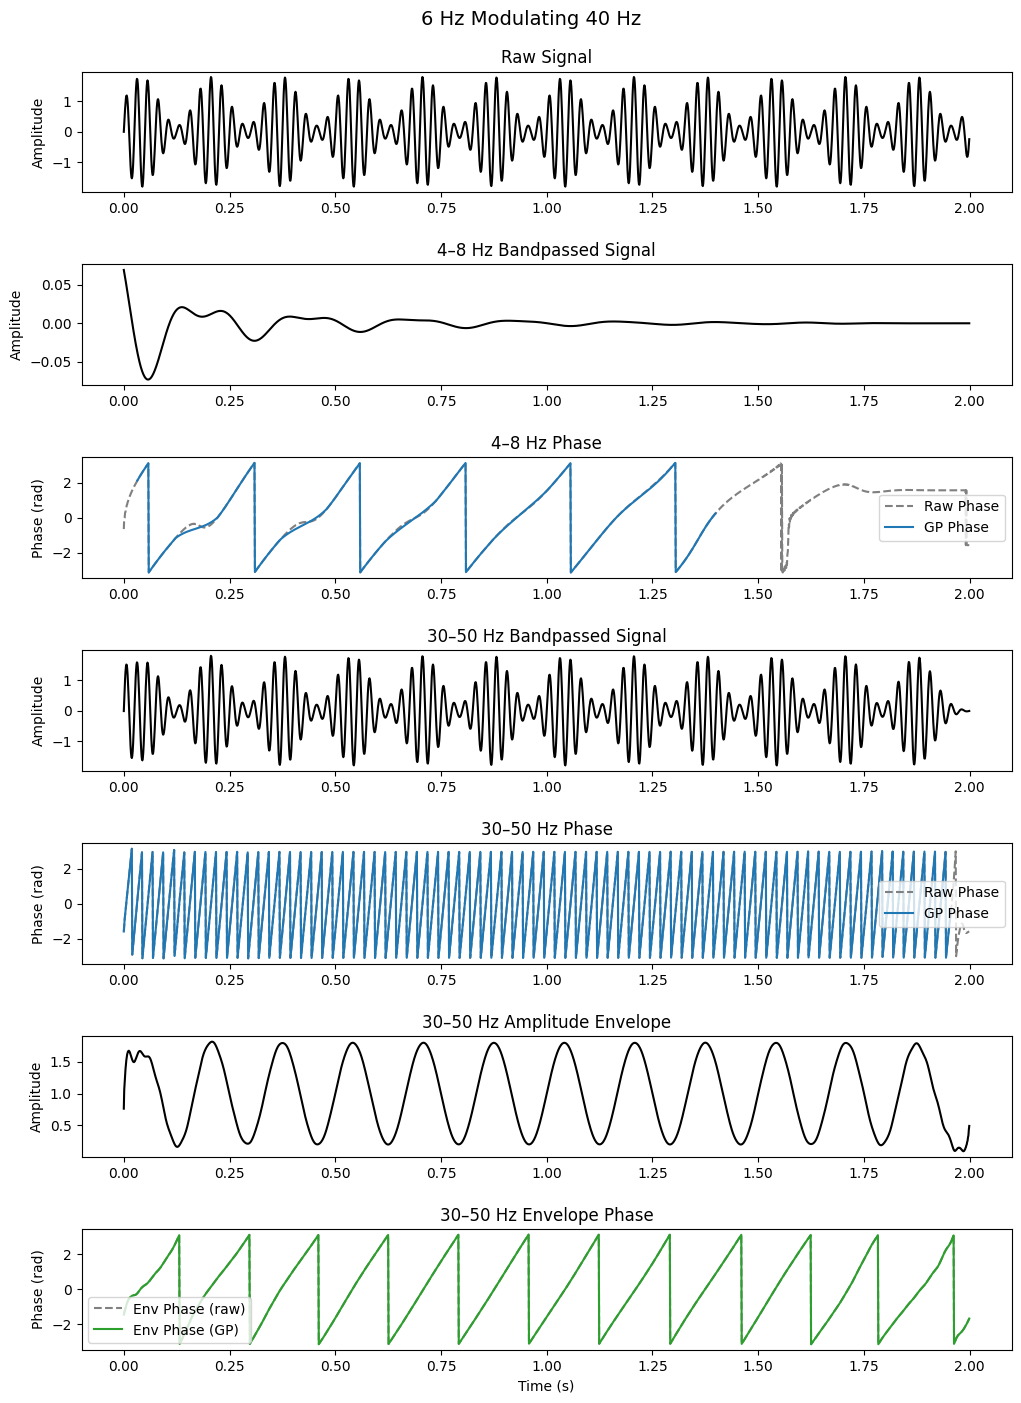

In [3]:
# Time vector
Fs = 1000  # Hz
t = np.arange(0, 2, 1/Fs)  # 2 seconds

# 6 Hz modulates 40 Hz
modulator1 = 1 + 0.8 * np.sin(2 * np.pi * 6 * t)
carrier1 = np.sin(2 * np.pi * 40 * t)
signal1 = modulator1 * carrier1
plot = analyze_phase_amplitude_structure(signal1, Fs, bands=[(4,8), (30,50)], envelope_bands=[(30,50)], plot_debug=False, fig_title='6 Hz Modulating 40 Hz')

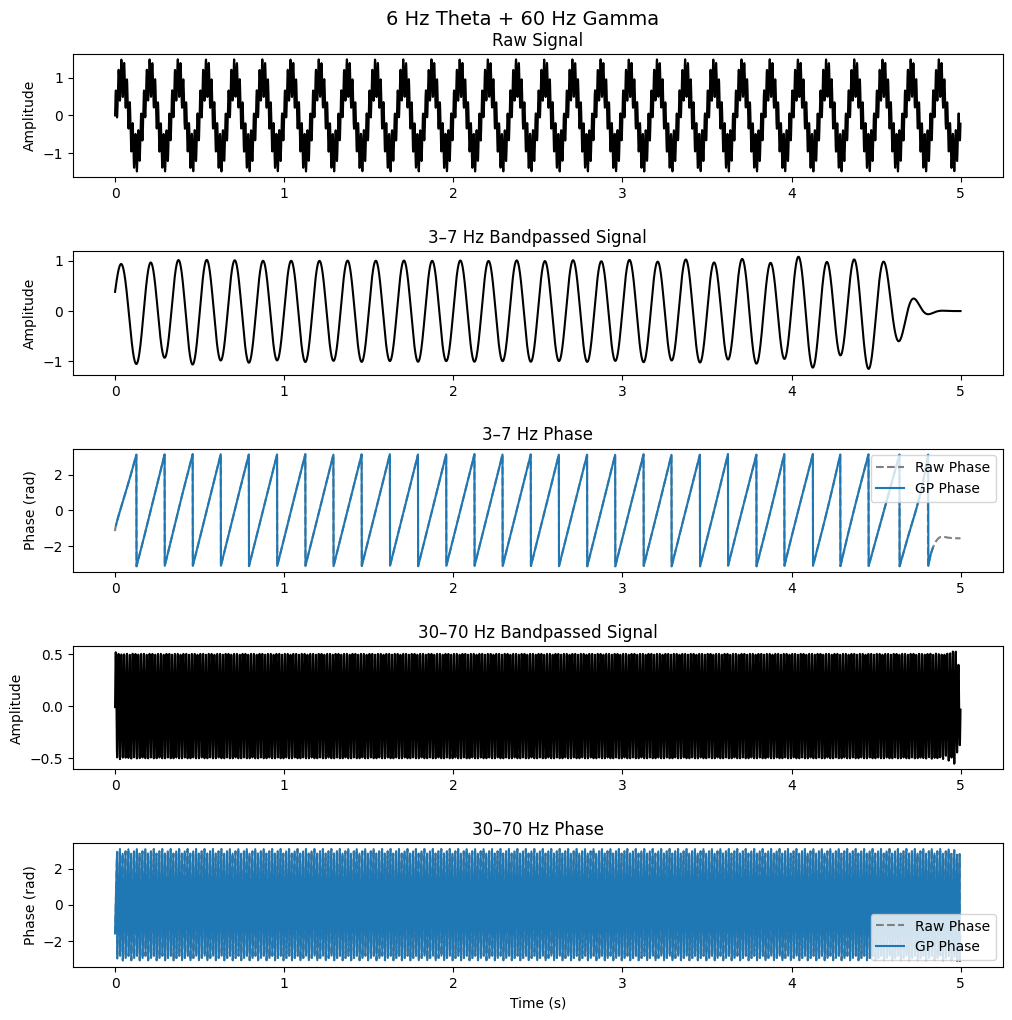

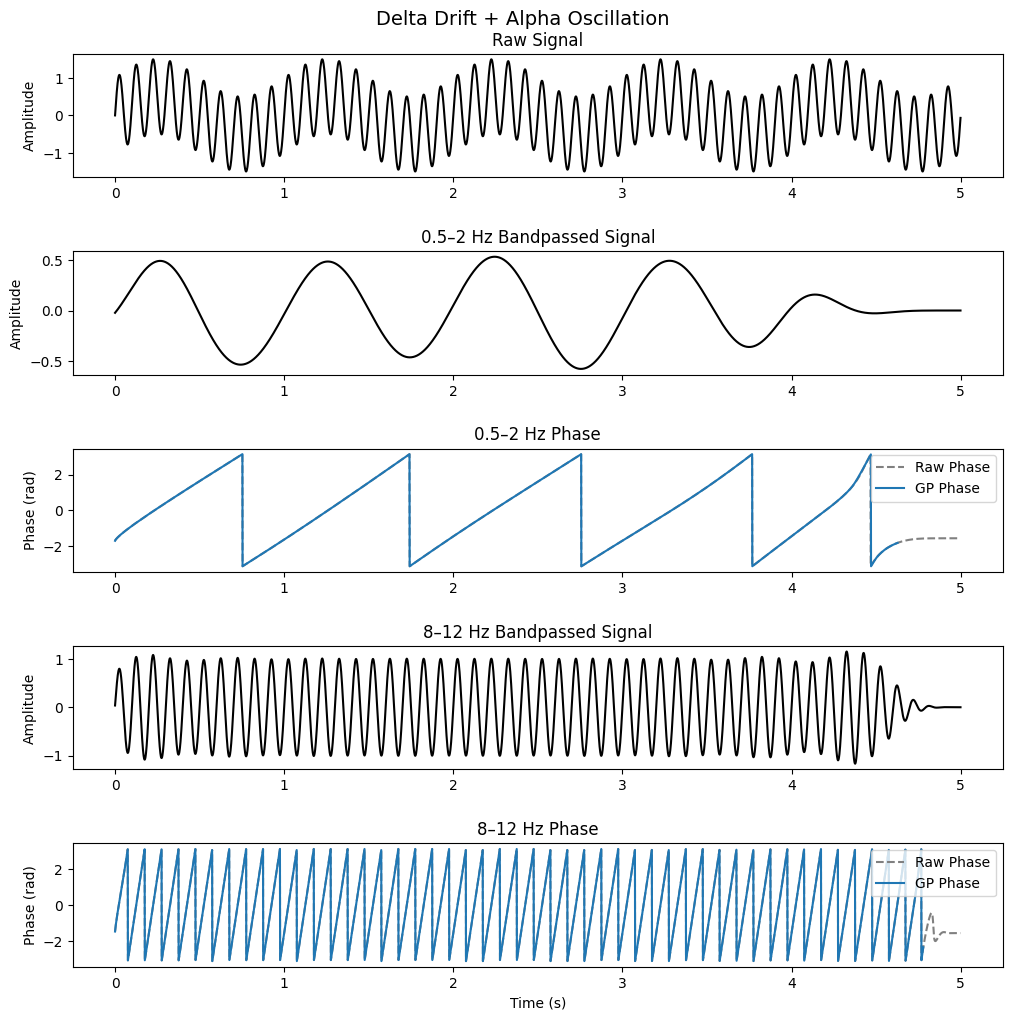

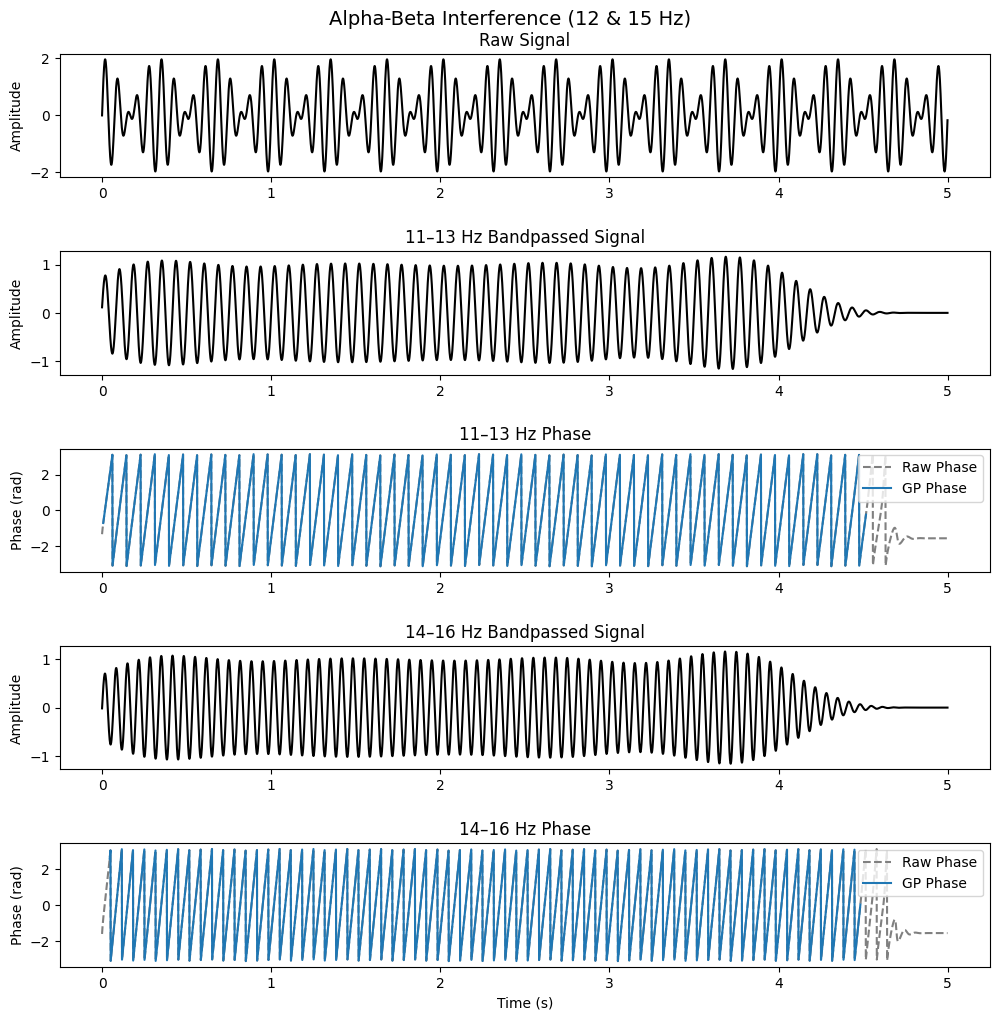

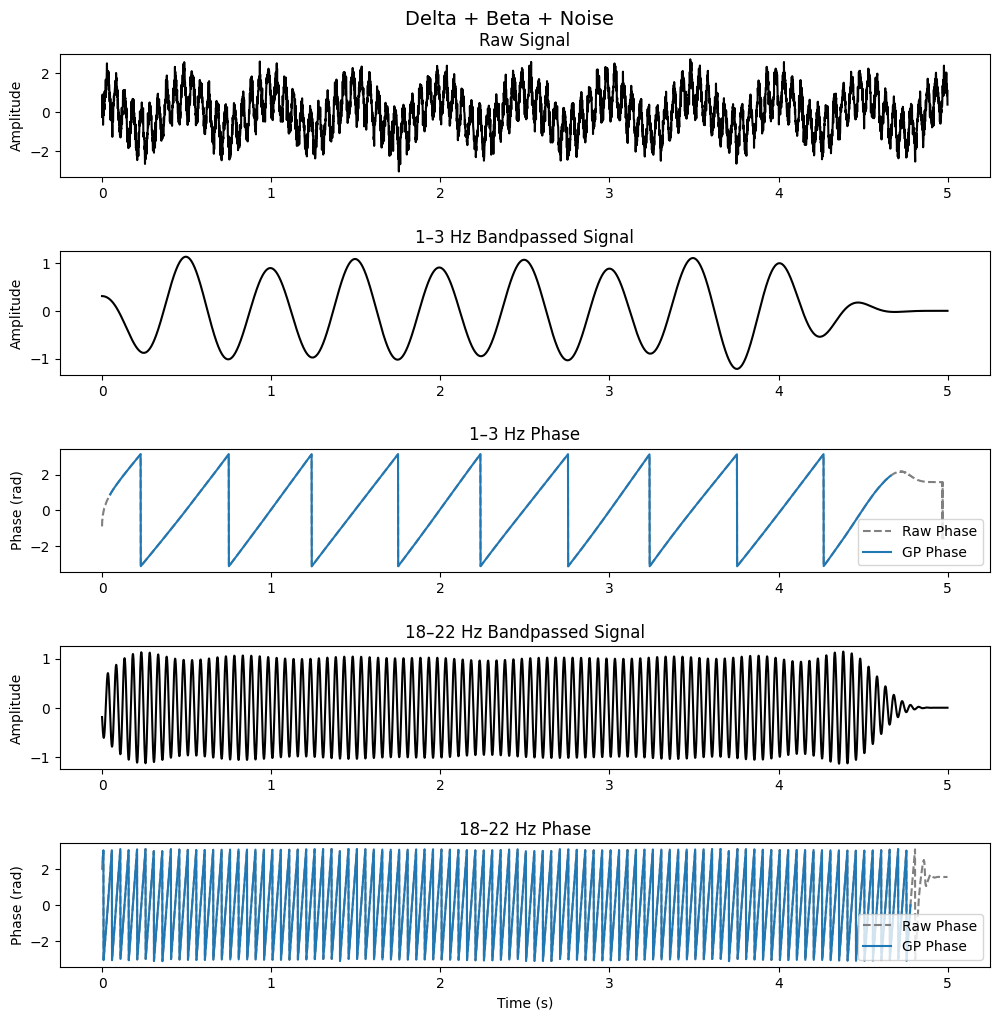

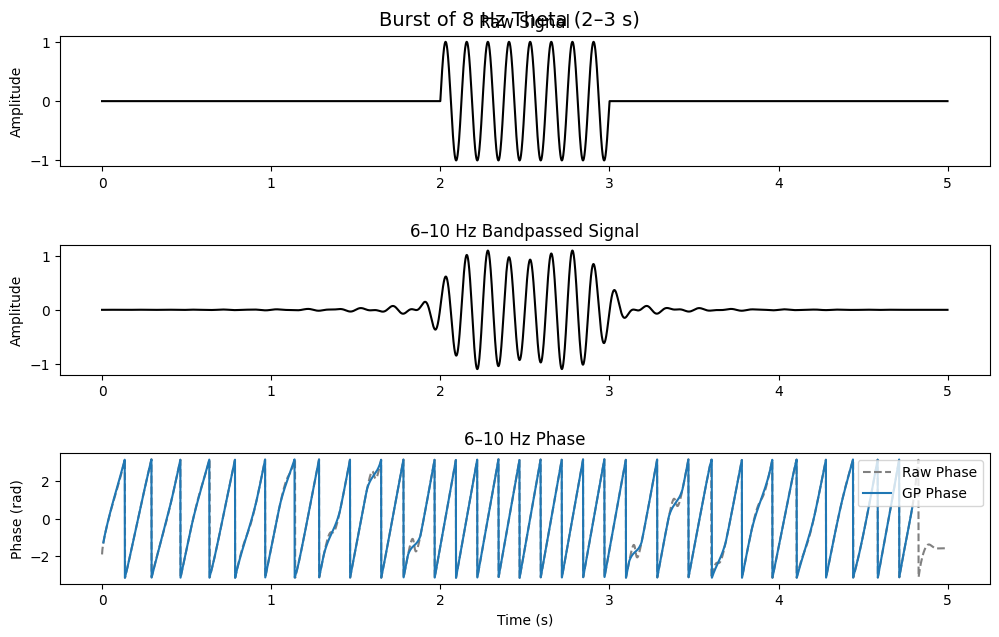

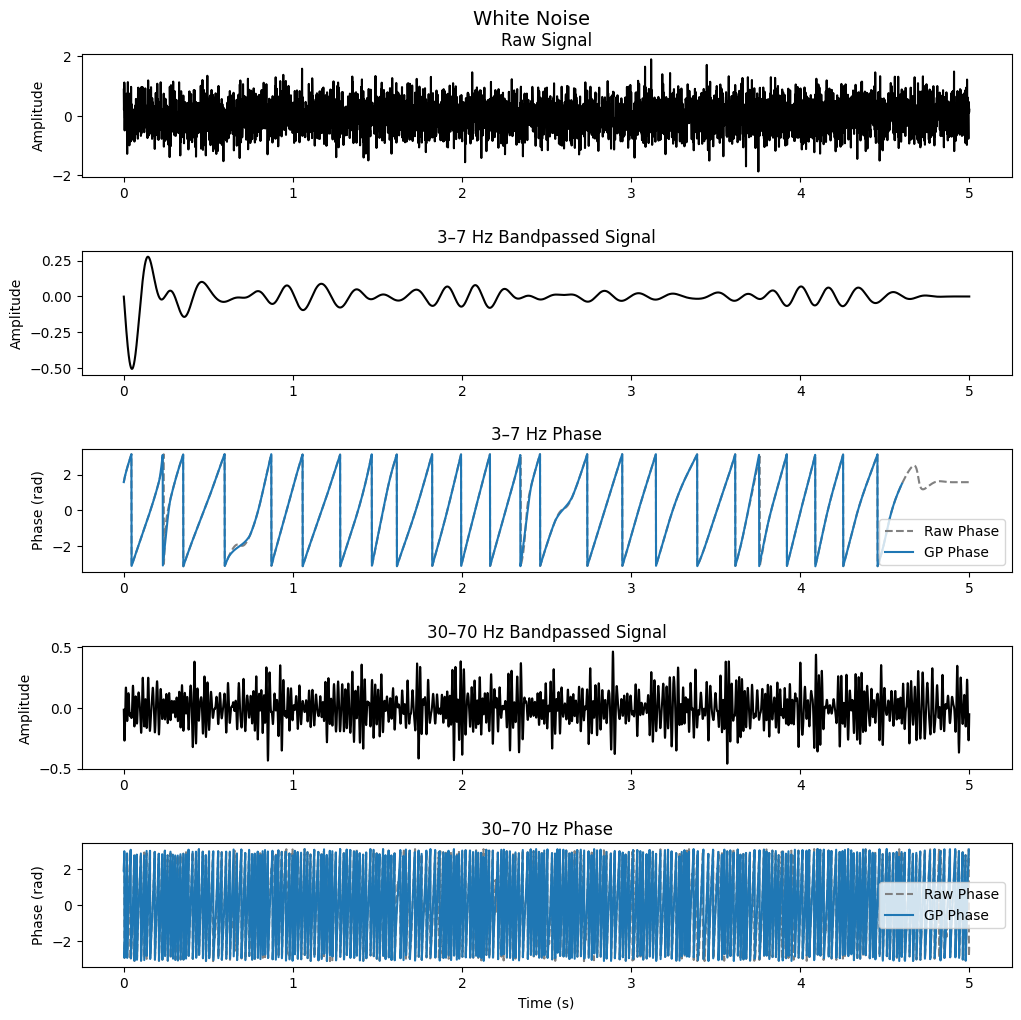

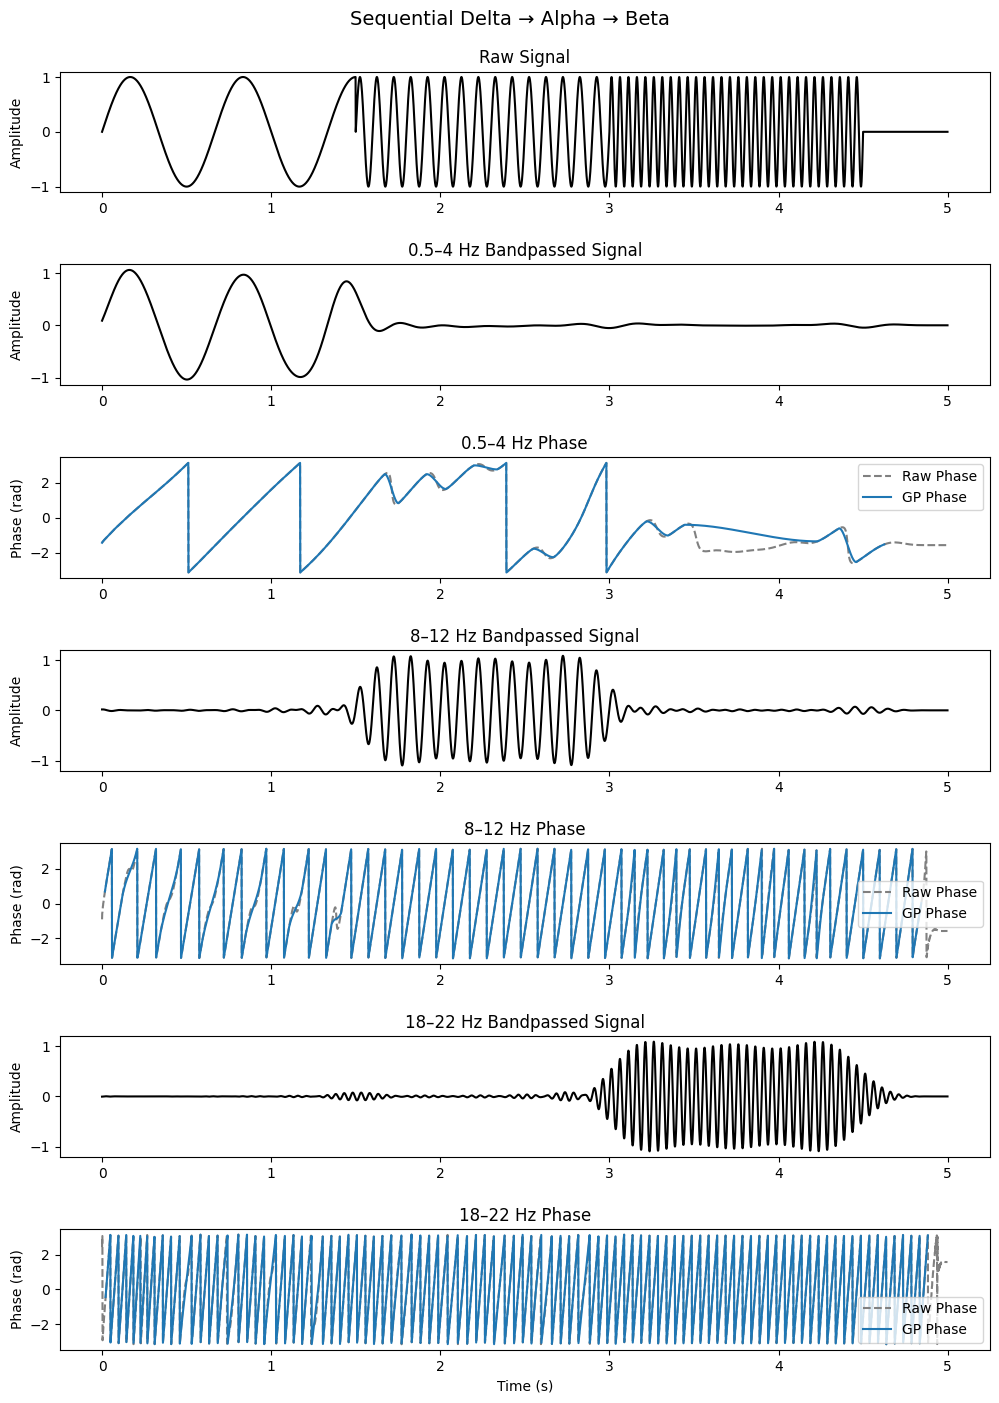

In [ ]:
# Sampling settings
Fs = 1000  # Hz
duration = 5.0  # seconds
t = np.arange(0, duration, 1 / Fs)

# Theta (6 Hz) + Gamma (60 Hz)
signal2 = np.sin(2 * np.pi * 6 * t) + 0.5 * np.sin(2 * np.pi * 60 * t)
analyze_phase_amplitude_structure(signal2, Fs, bands=[(3, 7), (30, 70)], fig_title='6 Hz Theta + 60 Hz Gamma')

# Slow drift (delta) + alpha (10 Hz) oscillation
signal7 = 0.5 * np.sin(2 * np.pi * 1 * t) + np.sin(2 * np.pi * 10 * t)
analyze_phase_amplitude_structure(signal7, Fs, bands=[(0.5, 2), (8, 12)], fig_title='Delta Drift + Alpha Oscillation')

# Beat pattern: interference between 12 Hz and 15 Hz tones
signal9 = np.sin(2 * np.pi * 12 * t) + np.sin(2 * np.pi * 15 * t)
analyze_phase_amplitude_structure(signal9, Fs, bands=[(11,13), (14,16)], fig_title='Alpha-Beta Interference (12 & 15 Hz)')

# 10. Embedded delta + beta, with random phase and noise
delta = np.sin(2 * np.pi * 2 * t + np.random.rand() * 2 * np.pi)
beta = np.sin(2 * np.pi * 20 * t + np.random.rand() * 2 * np.pi)
noise = 0.3 * np.random.randn(len(t))
signal10 = delta + beta + noise
analyze_phase_amplitude_structure(signal10, Fs, bands=[(1, 3), (18, 22)], fig_title='Delta + Beta + Noise')

# Burst of 8 Hz theta in the middle of signal
signal5 = np.zeros_like(t)
burst_region = (t > 2) & (t < 3)
signal5[burst_region] = np.sin(2 * np.pi * 8 * t[burst_region])
analyze_phase_amplitude_structure(signal5, Fs, bands=[(6, 10)], fig_title='Burst of 8 Hz Theta (2–3 s)')

# White noise (broadband)
np.random.seed(0)
signal3 = np.random.randn(len(t)) * 0.5
analyze_phase_amplitude_structure(signal3, Fs, bands=[(3, 7), (30, 70)], fig_title='White Noise')

# Bursts of mixed frequencies: delta, alpha, beta in sequence
signal12 = np.zeros_like(t)
signal12[(t >= 0) & (t < 1.5)] = np.sin(2 * np.pi * 1.5 * t[(t >= 0) & (t < 1.5)])  # delta
signal12[(t >= 1.5) & (t < 3)] = np.sin(2 * np.pi * 10 * t[(t >= 1.5) & (t < 3)])   # alpha
signal12[(t >= 3) & (t < 4.5)] = np.sin(2 * np.pi * 20 * t[(t >= 3) & (t < 4.5)])   # beta
analyze_phase_amplitude_structure(signal12, Fs, bands=[(0.5, 4), (8, 12), (18, 22)], fig_title='Sequential Delta → Alpha → Beta')

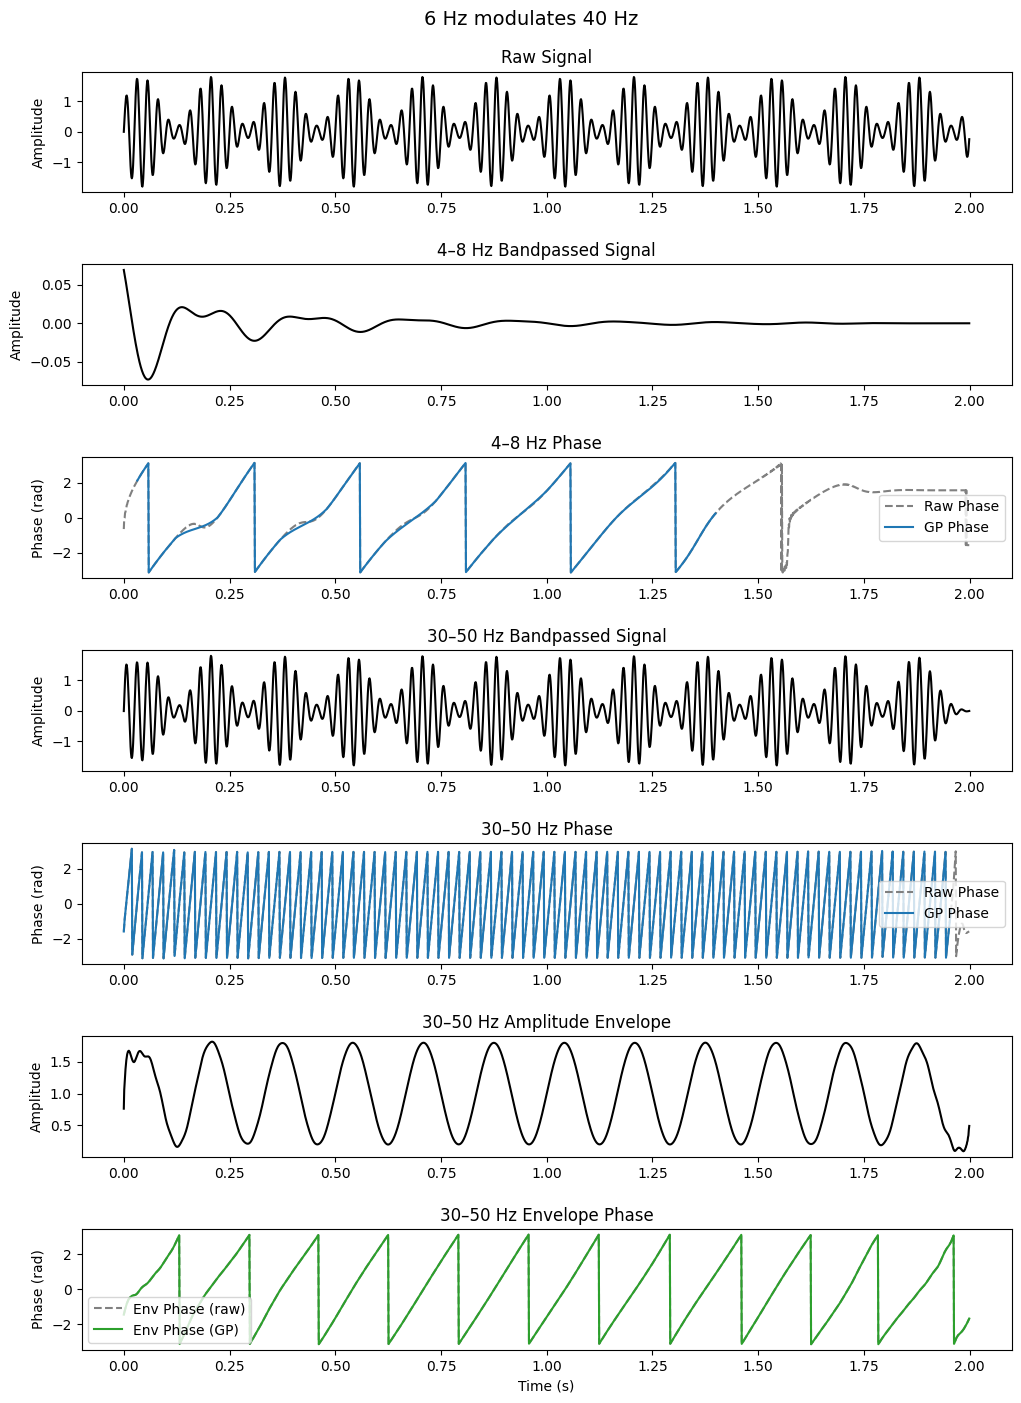

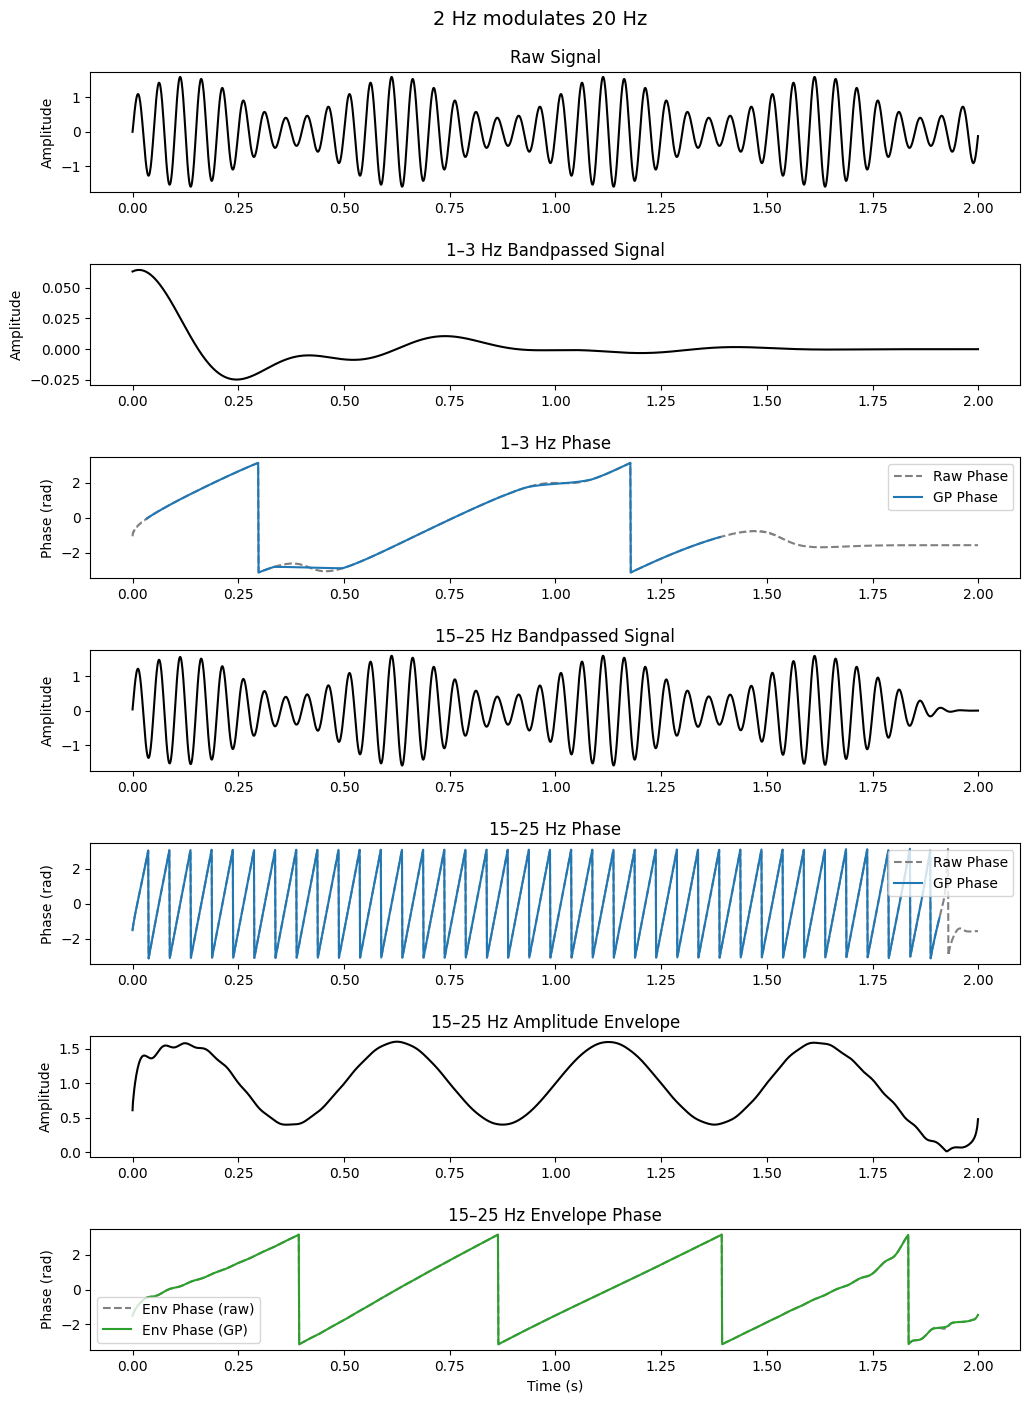

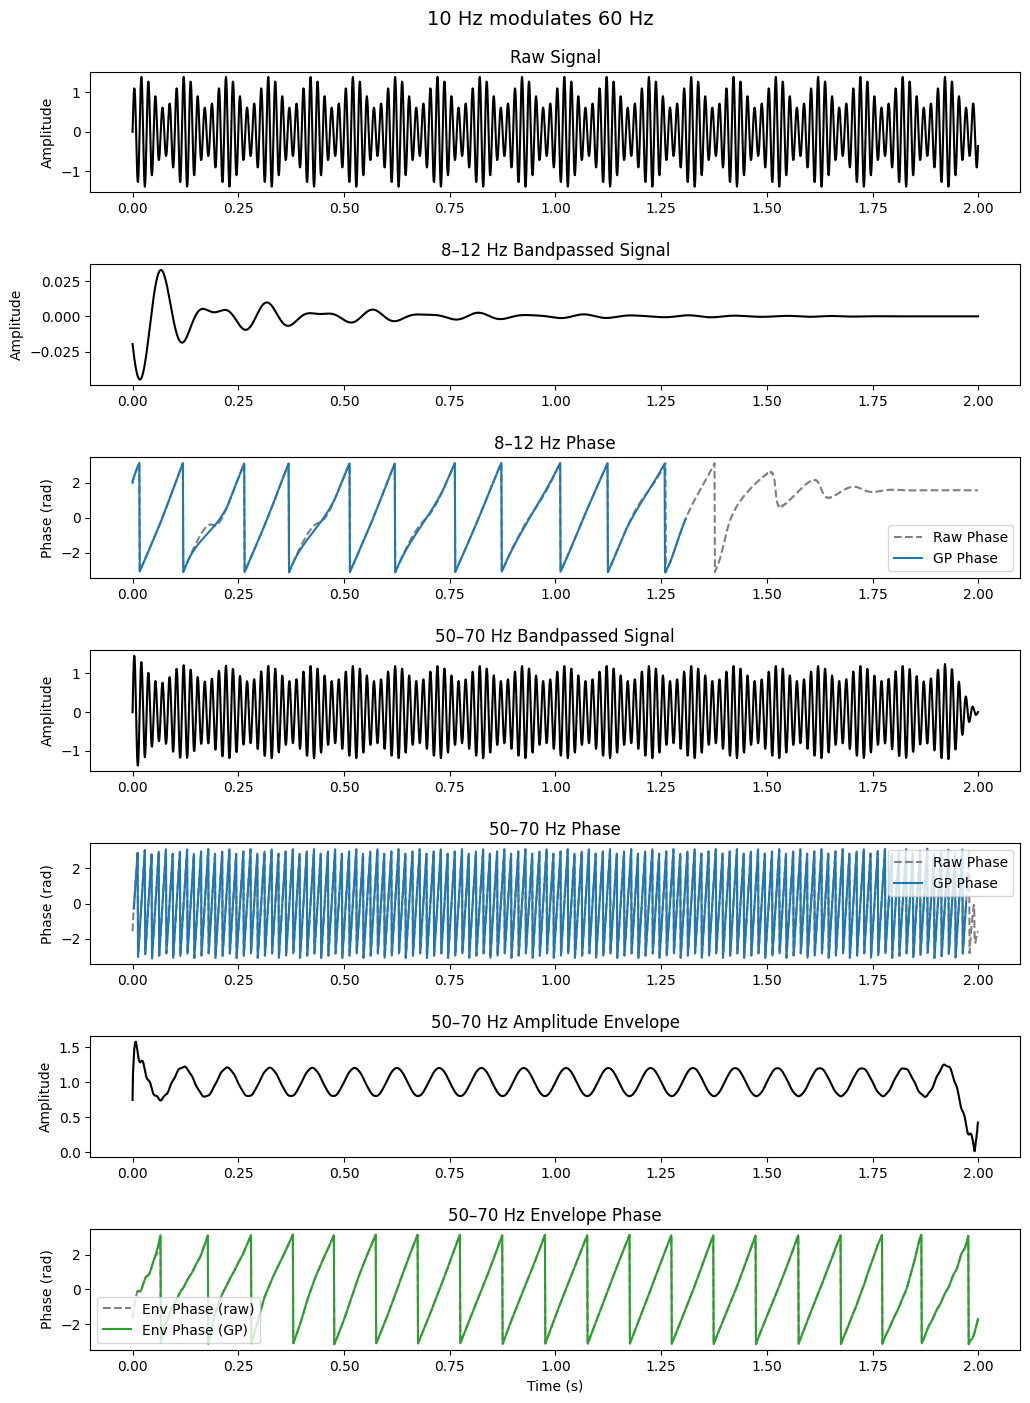

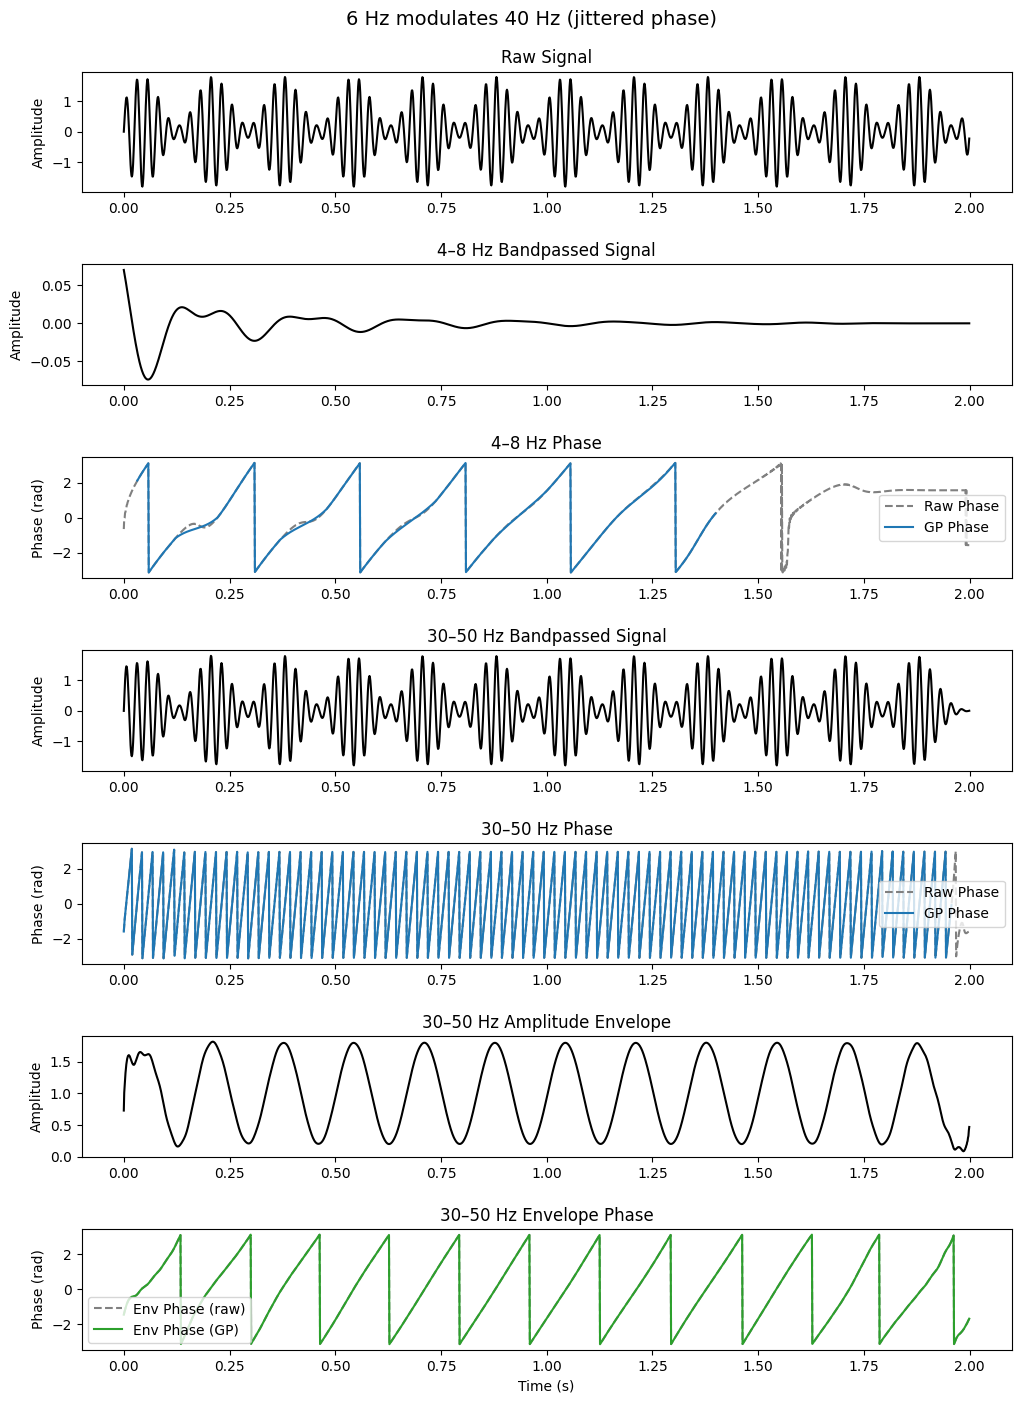

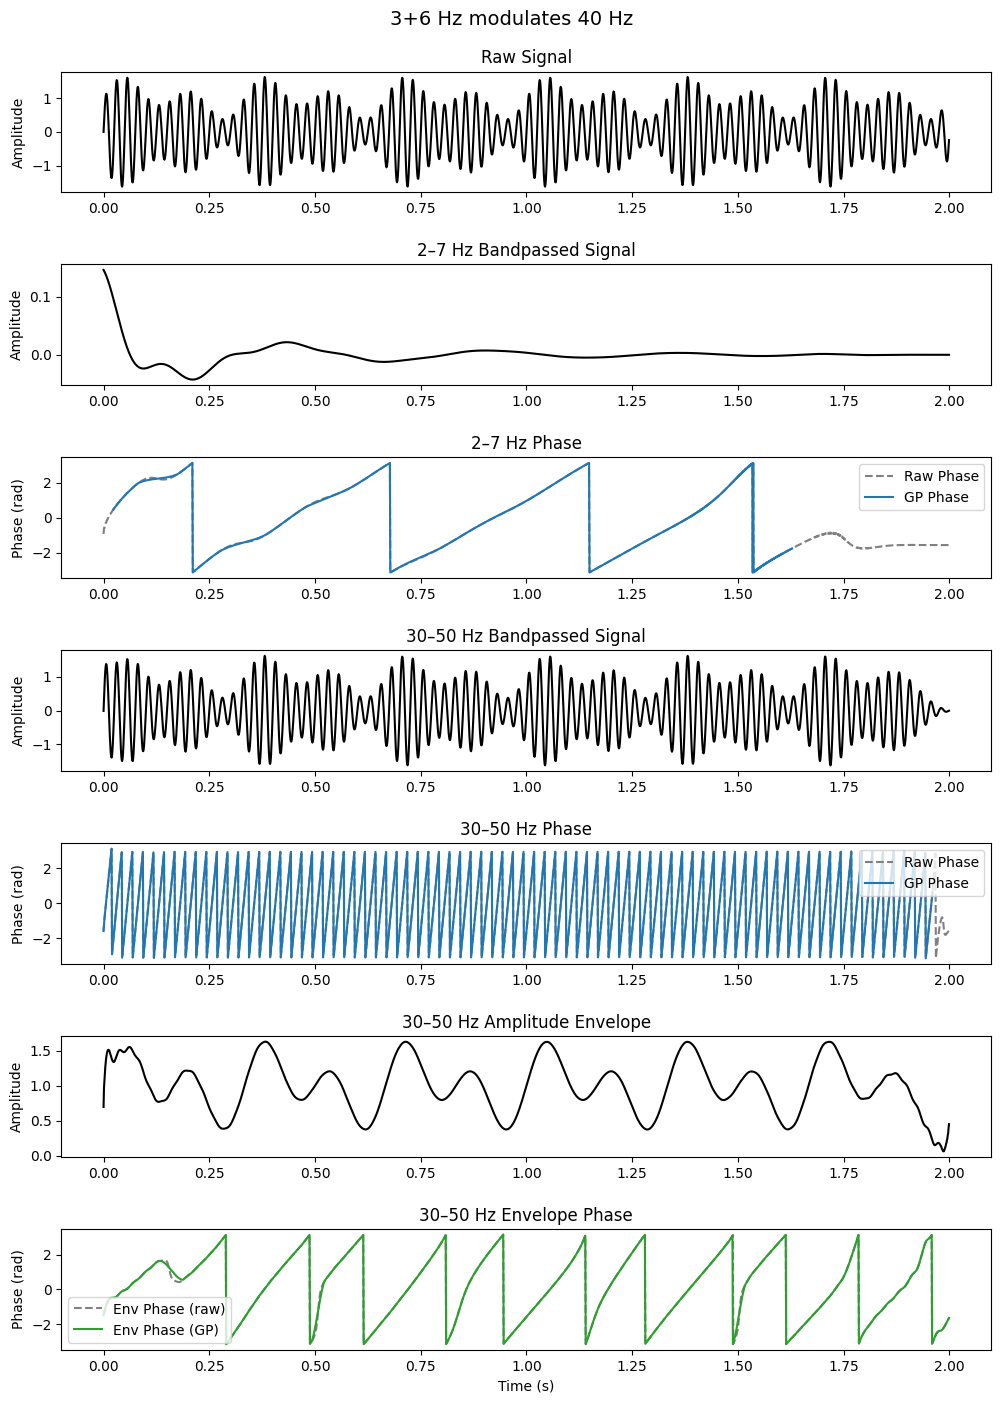

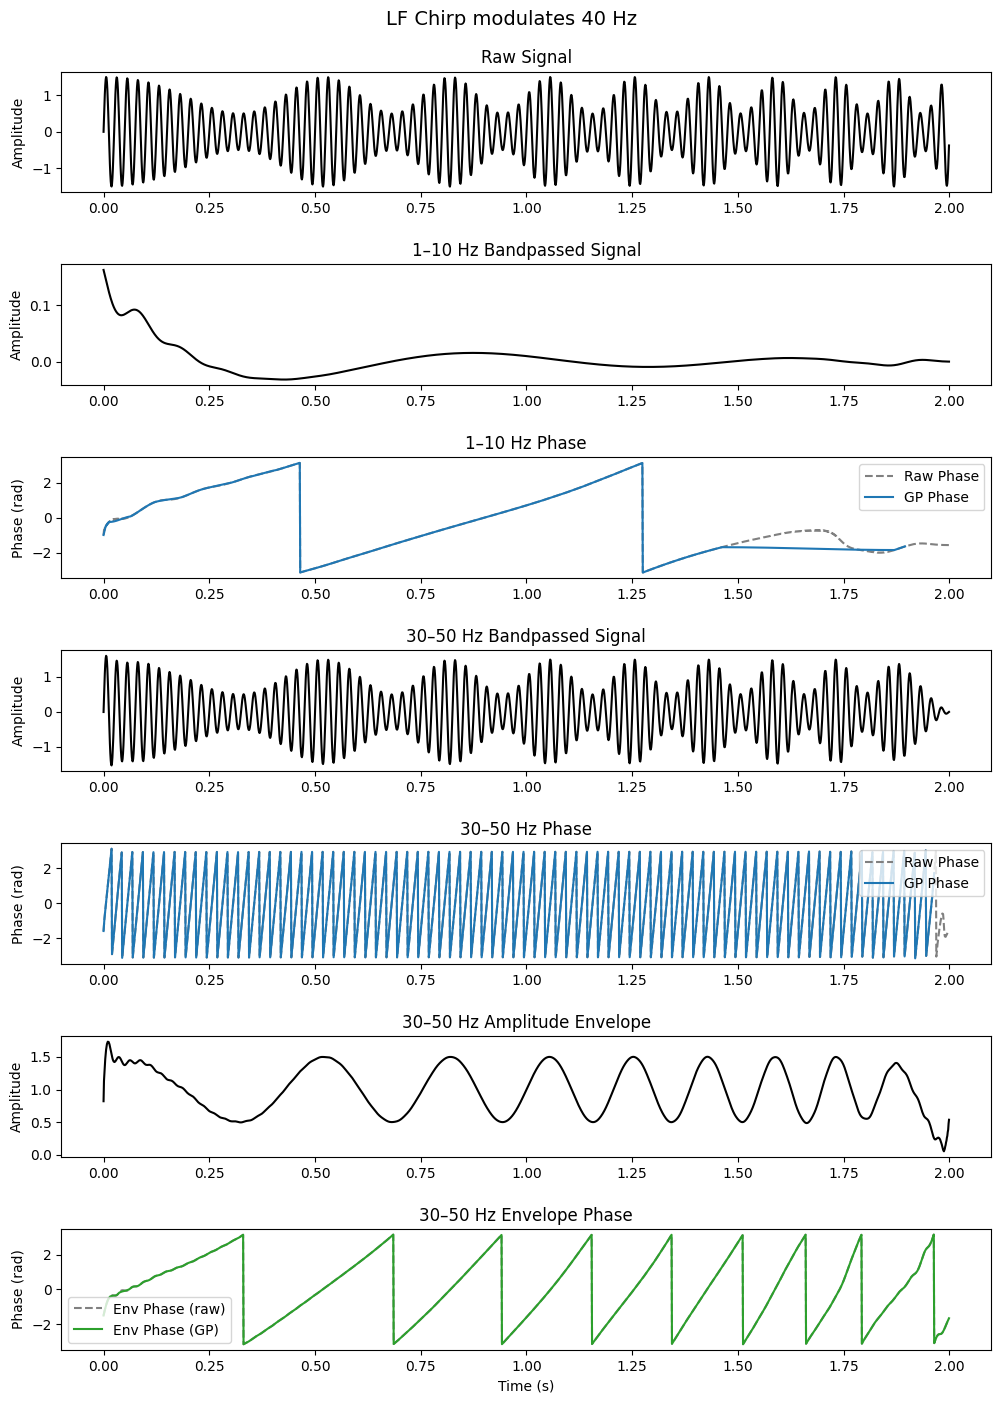

In [ ]:
# Time vector
Fs = 1000  # Hz
t = np.arange(0, 2, 1/Fs)  # 2 seconds

# 6 Hz modulates 40 Hz
modulator1 = 1 + 0.8 * np.sin(2 * np.pi * 6 * t)
carrier1 = np.sin(2 * np.pi * 40 * t)
signal1 = modulator1 * carrier1
analyze_phase_amplitude_structure(signal1, Fs, bands=[(4, 8), (30, 50)], envelope_bands=[(30,50)], fig_title="6 Hz modulates 40 Hz")

# 2 Hz modulates 20 Hz (Delta × Beta)
modulator2 = 1 + 0.6 * np.sin(2 * np.pi * 2 * t)
carrier2 = np.sin(2 * np.pi * 20 * t)
signal2 = modulator2 * carrier2
analyze_phase_amplitude_structure(signal2, Fs, bands=[(1, 3), (15, 25)], envelope_bands=[(15,25)], fig_title="2 Hz modulates 20 Hz")

# 10 Hz modulates 60 Hz (Alpha × High Gamma)
modulator3 = 1 + 0.4 * np.sin(2 * np.pi * 10 * t)
carrier3 = np.sin(2 * np.pi * 60 * t)
signal3 = modulator3 * carrier3
analyze_phase_amplitude_structure(signal3, Fs, bands=[(8, 12), (50, 70)], envelope_bands=[(50,70)], fig_title="10 Hz modulates 60 Hz")

# Mixed modulator (3 Hz + 6 Hz) modulates 40 Hz
modulator7 = 1 + 0.4 * np.sin(2 * np.pi * 6 * t) + 0.3 * np.sin(2 * np.pi * 3 * t)
carrier7 = np.sin(2 * np.pi * 40 * t)
signal7 = modulator7 * carrier7
analyze_phase_amplitude_structure(signal7, Fs, bands=[(2, 7), (30, 50)], envelope_bands=[(30,50)], fig_title="3+6 Hz modulates 40 Hz")

# Chirp modulator (LF ramp from 1 to 8 Hz) modulates 40 Hz
from scipy.signal import chirp
modulator8 = 1 + 0.5 * chirp(t, f0=1, f1=8, t1=2, method='linear')
carrier8 = np.sin(2 * np.pi * 40 * t)
signal8 = modulator8 * carrier8
analyze_phase_amplitude_structure(signal8, Fs, bands=[(1, 10), (30, 50)], envelope_bands=[(30,50)], fig_title="LF Chirp modulates 40 Hz")

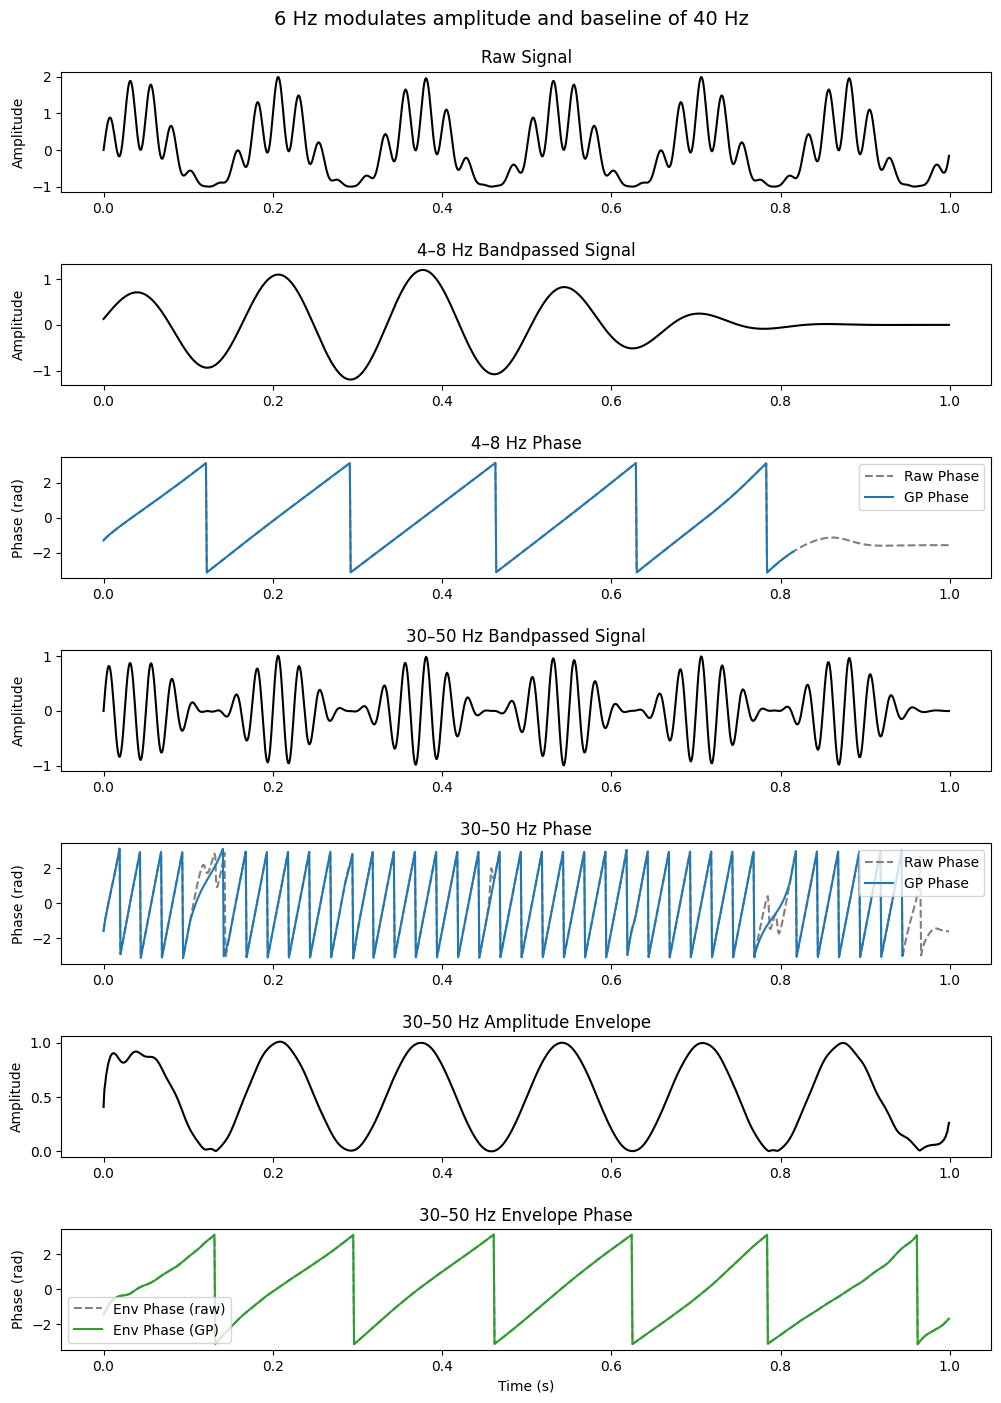

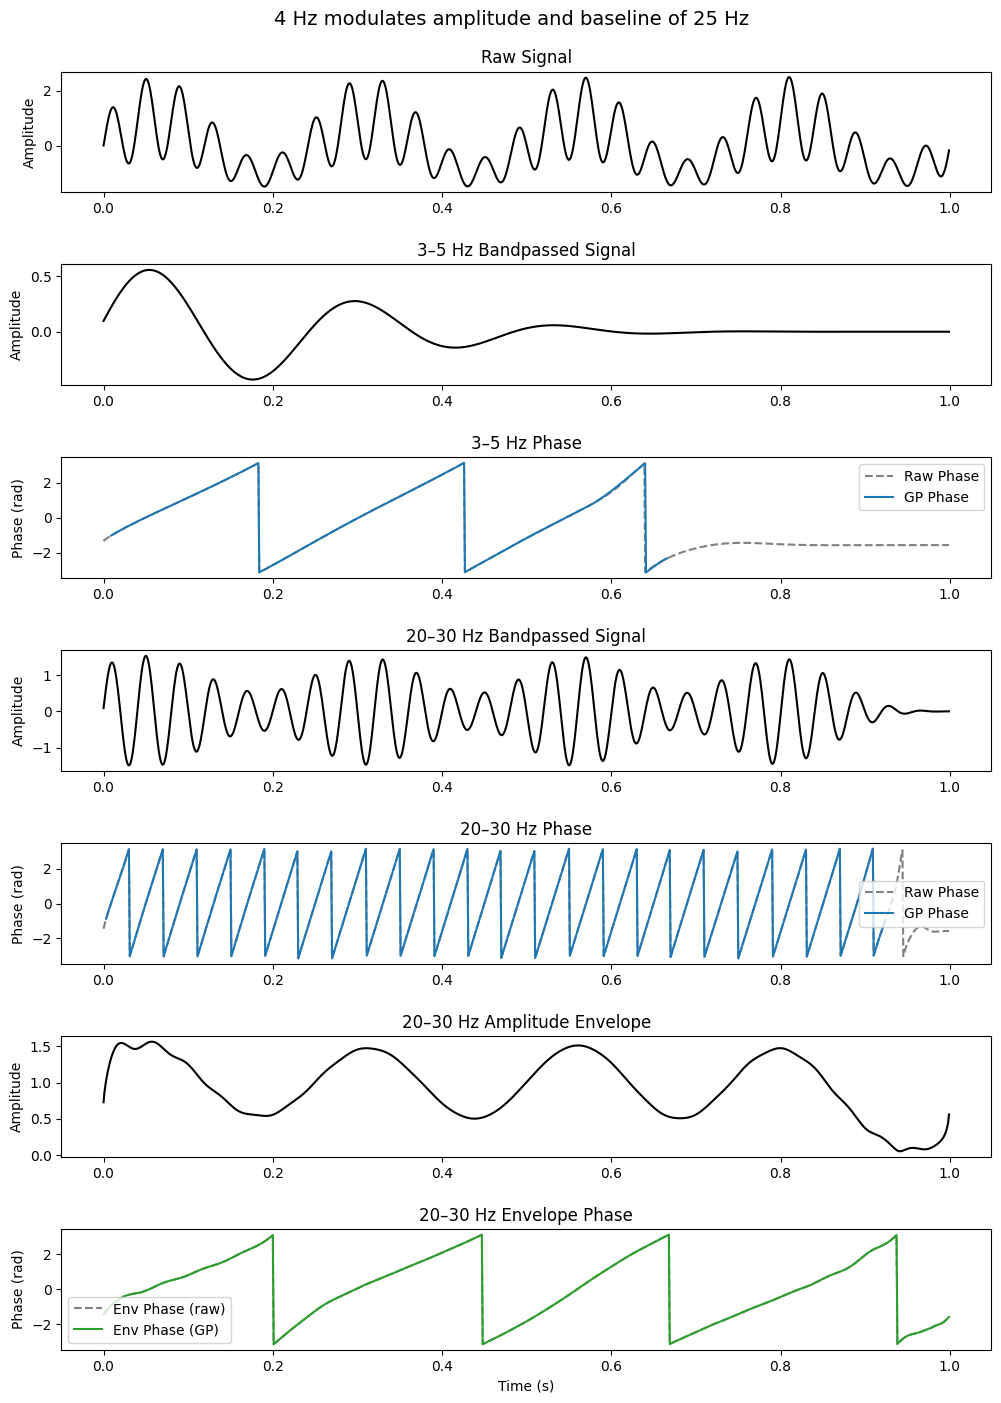

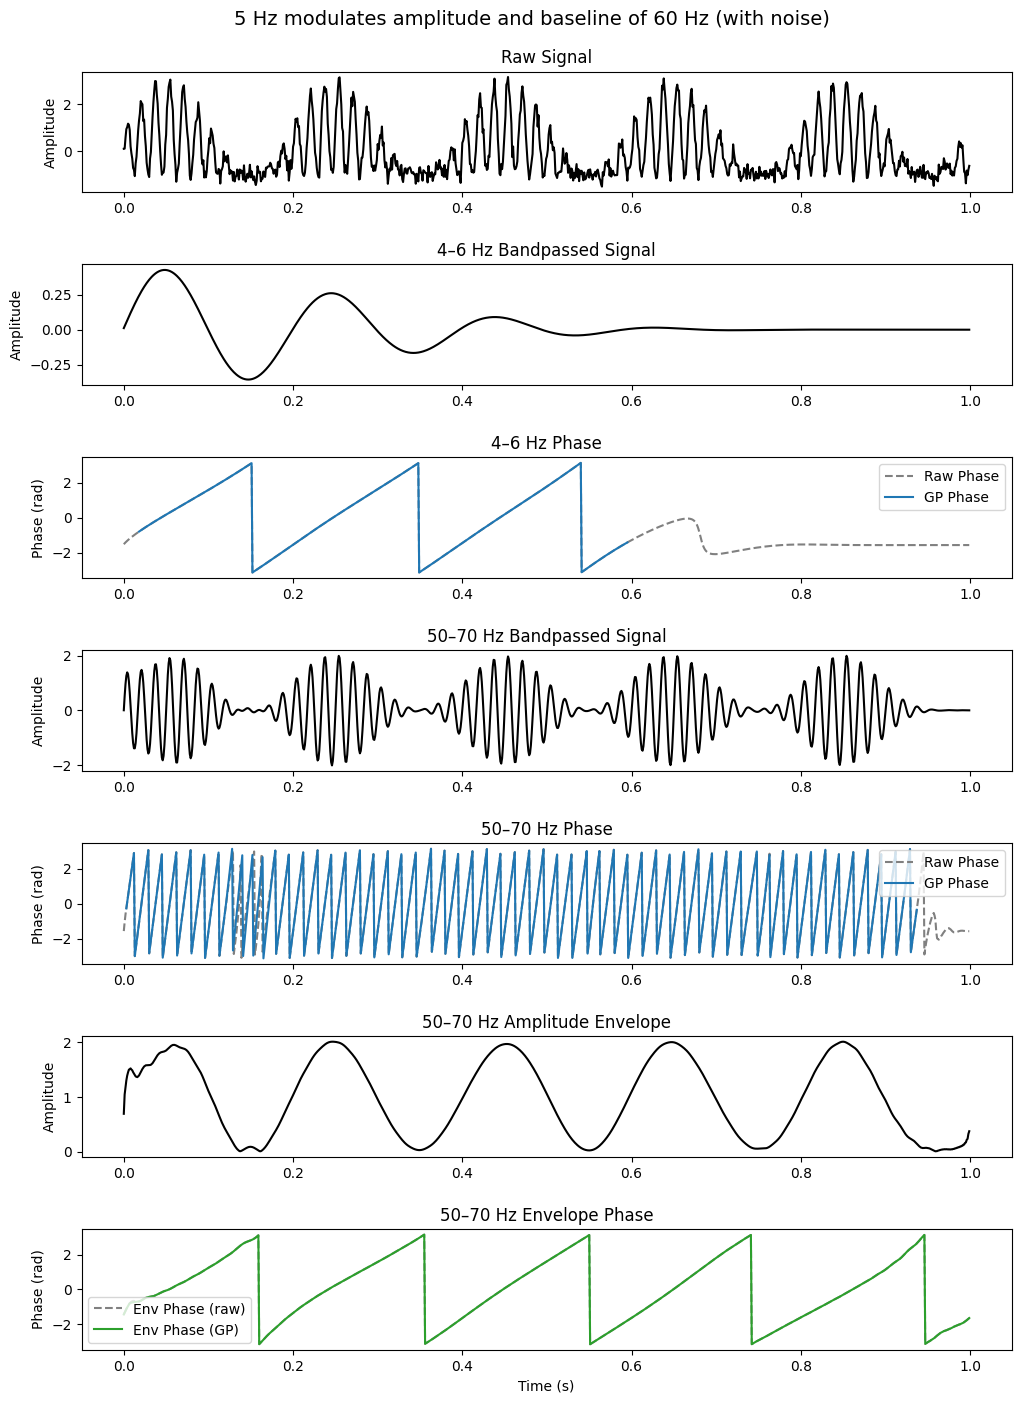

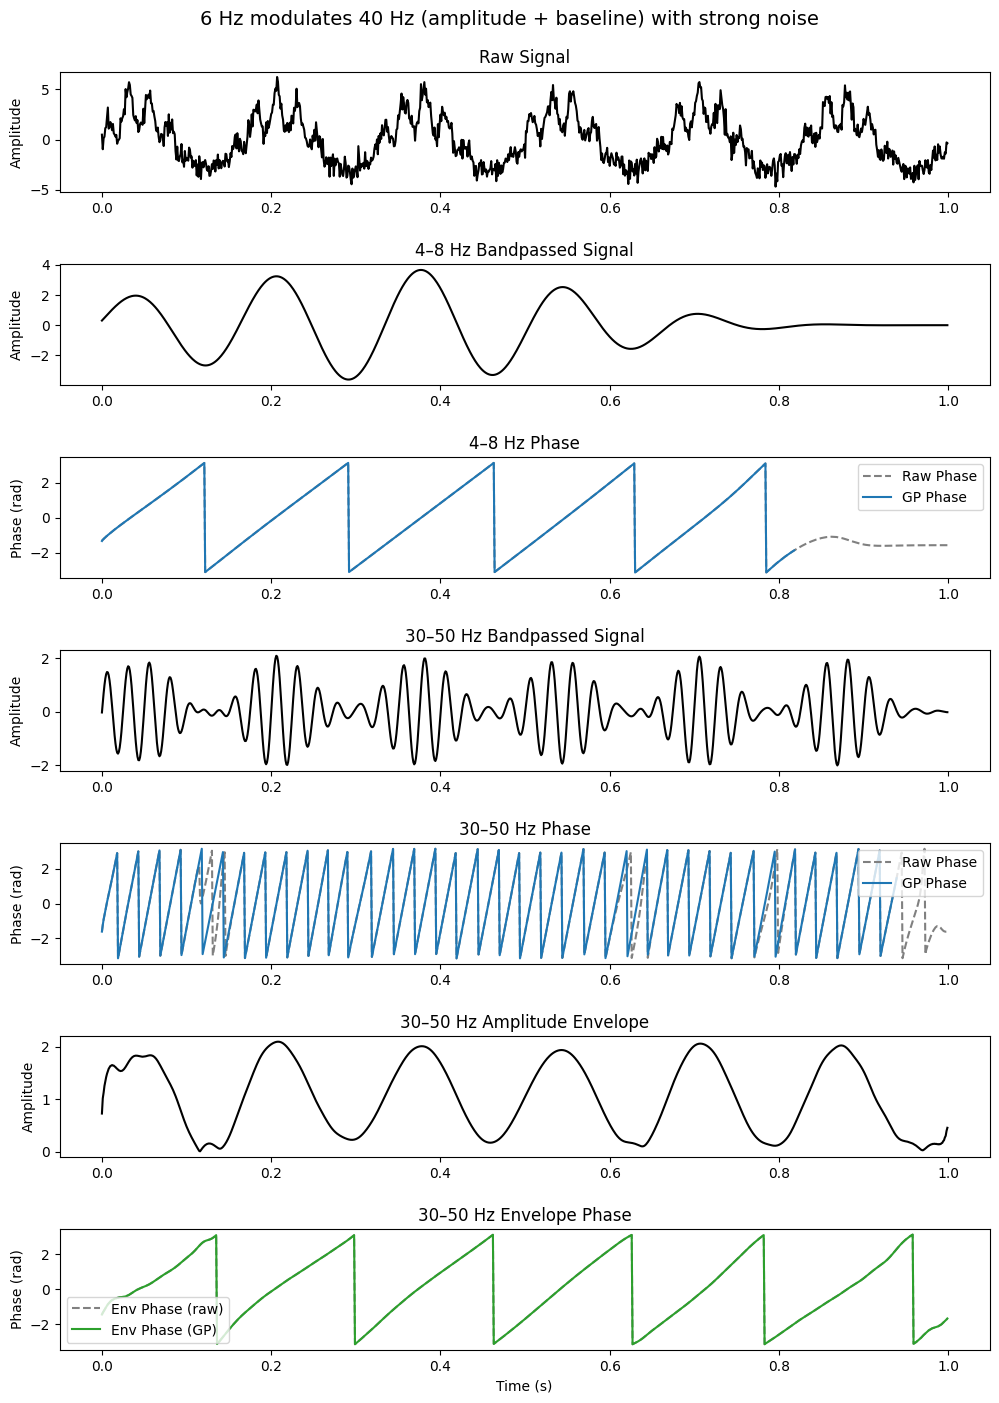

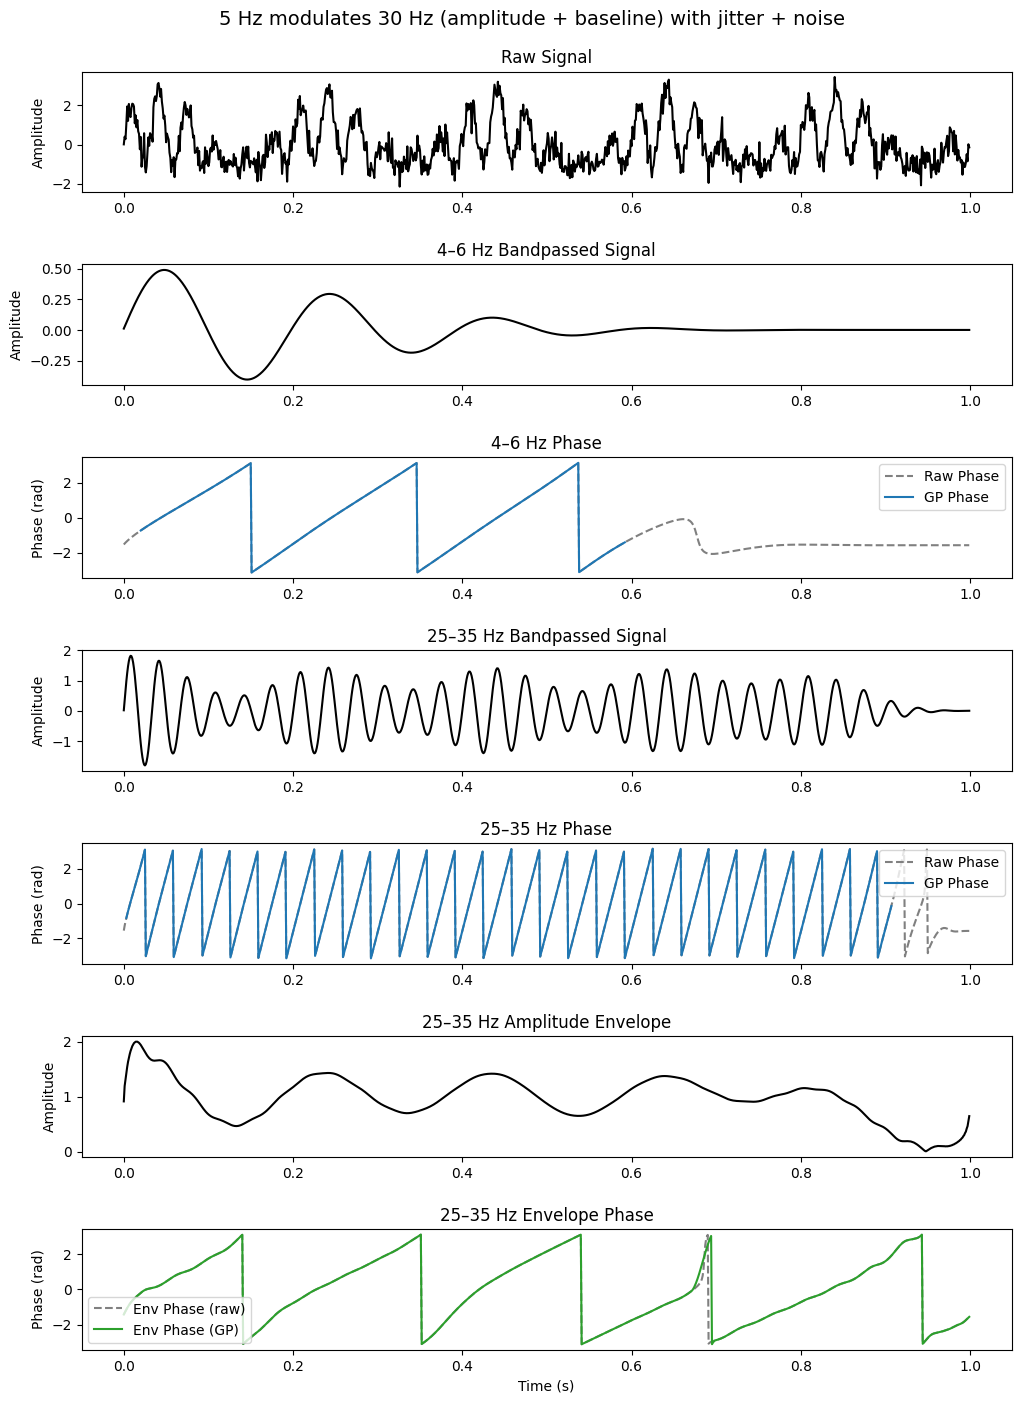

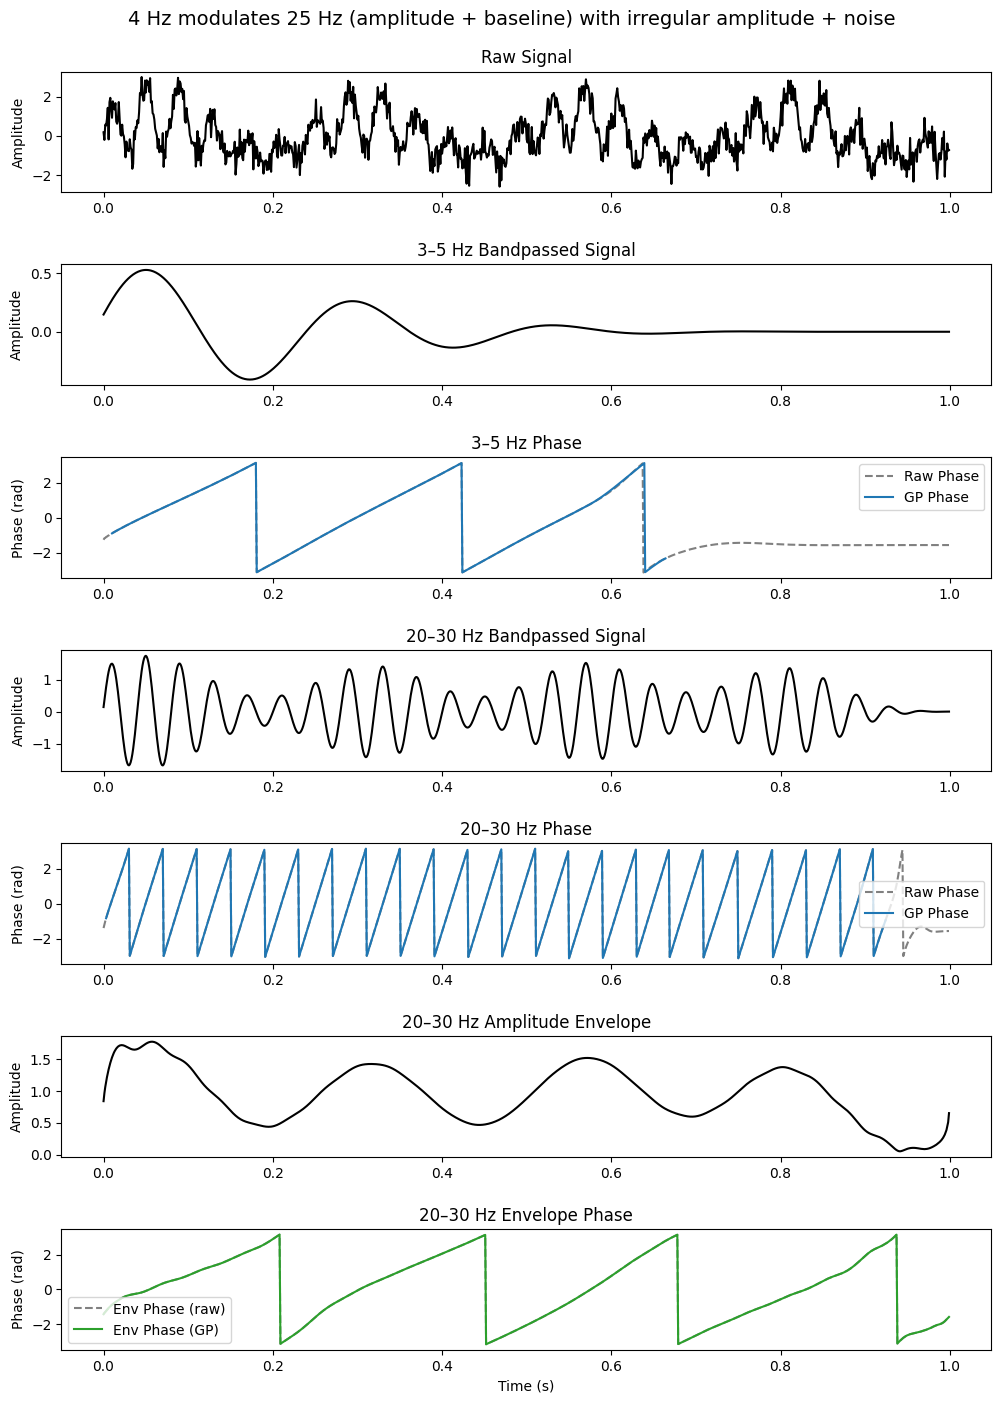

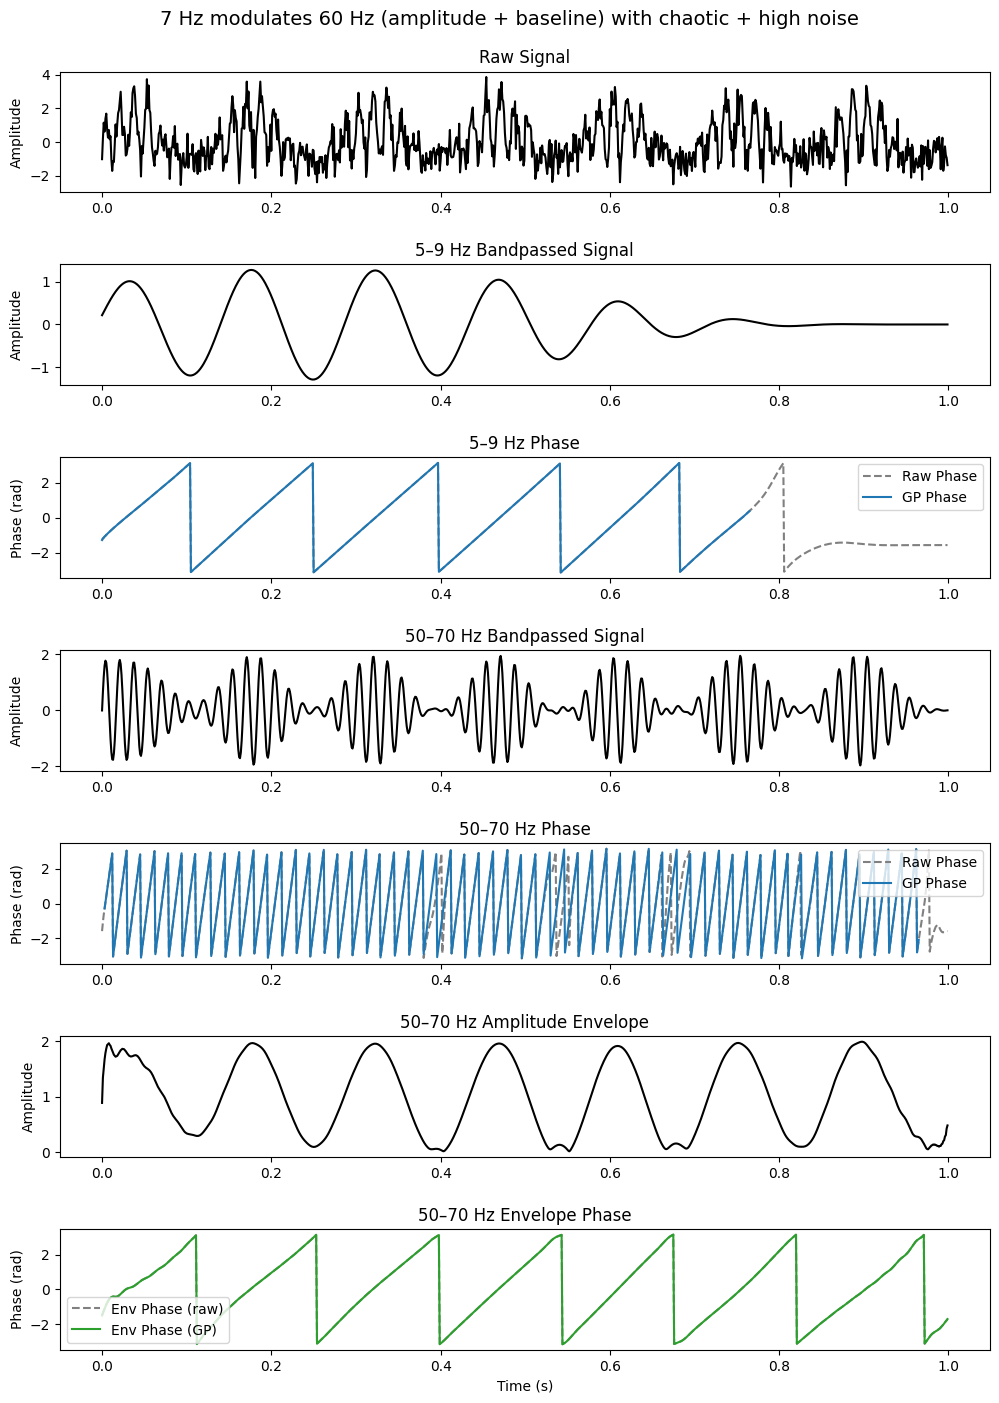

In [4]:
# Time vector and sampling rate
Fs = 1000  # Hz
t = np.arange(0, 1, 1/Fs)

# 6 Hz modulates amplitude AND centerline of 40 Hz
lf = np.sin(2 * np.pi * 6 * t)
hf = 0.5*np.sin(2 * np.pi * 40 * t)
signal1 = (1 + lf) * hf + lf
analyze_phase_amplitude_structure(signal1, Fs, bands=[(4, 8),  (30, 50)], envelope_bands=[(30,50)],  fig_title="6 Hz modulates amplitude and baseline of 40 Hz")

# 4 Hz modulates amplitude and baseline of 25 Hz
lf = np.sin(2 * np.pi * 4 * t)
hf = np.sin(2 * np.pi * 25 * t)
signal4 = (1 + 0.5 * lf) * hf + lf
analyze_phase_amplitude_structure(signal4, Fs, bands=[(3, 5),  (20, 30)], envelope_bands=[(20, 30)],  fig_title="4 Hz modulates amplitude and baseline of 25 Hz")

# 5 Hz modulates amplitude and baseline of 60 Hz with noise
lf = np.sin(2 * np.pi * 5 * t)
hf = np.sin(2 * np.pi * 60 * t)
noise = 0.2 * np.random.randn(len(t))
signal5 = (1 + lf) * hf + lf + noise
analyze_phase_amplitude_structure(signal5, Fs, bands=[(4, 6),  (50, 70)], envelope_bands=[(50, 70)], fig_title="5 Hz modulates amplitude and baseline of 60 Hz (with noise)")

# Strong noise, 6 Hz modulating 40 Hz
lf = np.sin(2 * np.pi * 6 * t)
hf = np.sin(2 * np.pi * 40 * t)
noise = 0.6 * np.random.randn(len(t))
signal1 = (1 + lf) * hf + 3*lf + noise
analyze_phase_amplitude_structure(signal1, Fs, bands=[(4, 8),  (30, 50)], envelope_bands=[(30,50)], fig_title="6 Hz modulates 40 Hz (amplitude + baseline) with strong noise")

# Phase jittered 5 Hz modulator + 30 Hz carrier, noisy
lf_phase_jitter = np.sin(2 * np.pi * 5 * t + np.random.uniform(-0.5, 0.5))
hf = np.sin(2 * np.pi * 30 * t)
noise = 0.4 * np.random.randn(len(t))
signal2 = (1 + 0.8 * lf_phase_jitter) * hf + lf_phase_jitter + noise
analyze_phase_amplitude_structure(signal2, Fs, bands=[(4, 6),  (25, 35)], envelope_bands=[(25, 35)],  fig_title="5 Hz modulates 30 Hz (amplitude + baseline) with jitter + noise")

# Random amplitude scaling, 4 Hz × 25 Hz, irregular amplitude
lf = np.sin(2 * np.pi * 4 * t)
hf = np.sin(2 * np.pi * 25 * t)
amp_scale = 1 + 0.5 * lf + 0.3 * np.random.randn(len(t))
signal4 = amp_scale * hf + lf + 0.4 * np.random.randn(len(t))
analyze_phase_amplitude_structure(signal4, Fs, bands=[(3, 5),  (20, 30)], envelope_bands=[(20, 30)],  fig_title="4 Hz modulates 25 Hz (amplitude + baseline) with irregular amplitude + noise")

# Phase-jittered modulator, 7 Hz × 60 Hz, high noise
lf = np.sin(2 * np.pi * 7 * t + np.random.uniform(-1, 1))
hf = np.sin(2 * np.pi * 60 * t)
signal5 = (1 + lf) * hf + lf + 0.6 * np.random.randn(len(t))
analyze_phase_amplitude_structure(signal5, Fs, bands=[(5, 9),  (50, 70)], envelope_bands=[(50, 70)],  fig_title="7 Hz modulates 60 Hz (amplitude + baseline) with chaotic + high noise")